## What is MLFlow and its Components

MLFLow is an open source platform to manage the ML lifecycle, including experimentation, reproducibility, deployment, and a central model registry. MLFLow currently offers four components:


<img src="mlflow.png">


https://www.mlflow.org/

_First thing first_
### Create Conda environment

##### run below commands in terminal but make sure conda is installed or use anaconda prompt which you will get as part of anaconda installation

1. `conda create -n envname python=3.9 ipykernel` 
it will create a conda env named envname and install python version 3.9 and a ipykernel inside this environment

2. Activate the environment
`conda activate envname`

3. add newly created environment to the notebook as kernel
`python -m ipykernel install --user --name=envname` 

4. install notebook inside the environment
`pip install notebook`

5. Now install all required dependencies to run this notebook

* `pip install pandas`
* `pip install numpy`
* `pip install scikit-learn`
* `pip install imblearn`
* `pip install matplotlib`
* `pip install mlflow`

Now open the notebook using below command: (from the anaconda prompt inside conda environment)

`jupyter notebook`


#### Make sure python is used from your newly created environment.

In [1]:
import sys
print(sys.executable)

C:\Users\Ashutosh Tripathi\anaconda3\envs\mlops\python.exe


In [2]:
!python --version

Python 3.9.12


### Create functions for all the steps involved in complete model training lifecycle

In [3]:
import pandas as pd
import numpy as np

In [4]:
def load_data(path):
    data = pd.read_csv(path)
    return data

In [5]:
data = load_data('https://raw.githubusercontent.com/TripathiAshutosh/dataset/main/banking.csv')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [6]:
def data_cleaning(data):
    print("na values available in data \n")
    print(data.isna().sum())
    data = data.dropna()
    print("after droping na values \n")
    print(data.isna().sum())
    return data

In [7]:
def preprocessing(data):
    data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
    data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
    data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])
    
    cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    for var in cat_vars:
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(data[var], prefix=var)
        data1=data.join(cat_list)
        data=data1

    cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    data_vars=data.columns.values.tolist()
    to_keep=[i for i in data_vars if i not in cat_vars]
    
    final_data=data[to_keep]
    
    
    final_data.columns = final_data.columns.str.replace('.','_')
    final_data.columns = final_data.columns.str.replace(' ','_')
    return final_data

In [8]:
def train_test_split(final_data):
    from sklearn.model_selection import train_test_split
    X = final_data.loc[:, final_data.columns != 'y']
    y = final_data.loc[:, final_data.columns == 'y']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify = y, random_state=47)
    return X_train, X_test, y_train, y_test

In [9]:
def over_sampling_target_class(X_train, y_train):
    ### Over-sampling using SMOTE 
    from imblearn.over_sampling import SMOTE
    os = SMOTE(random_state=0)

    columns = X_train.columns
    os_data_X,os_data_y=os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
    os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
    # we can Check the numbers of our data
    print("length of oversampled data is ",len(os_data_X))
    print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
    print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
    print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
    print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))
    
    X_train = os_data_X
    y_train = os_data_y['y']
 
    return X_train, y_train

In [12]:
def training_basic_classifier(X_train,y_train):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=101)
    model.fit(X_train, y_train)
    
    return model

In [13]:
def predict_on_test_data(model,X_test):
    y_pred = model.predict(X_test)
    return y_pred

In [14]:
def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred

In [15]:
def get_metrics(y_true, y_pred, y_pred_prob):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

In [16]:
def create_roc_auc_plot(clf, X_data, y_data):
    import matplotlib.pyplot as plt
    from sklearn import metrics
    metrics.plot_roc_curve(clf, X_data, y_data) 
    plt.savefig('roc_auc_curve.png')

In [17]:
def create_confusion_matrix_plot(clf, X_test, y_test):
    import matplotlib.pyplot as plt
    from sklearn.metrics import plot_confusion_matrix
    plot_confusion_matrix(clf, X_test, y_test)
    plt.savefig('confusion_matrix.png')

In [18]:
def hyper_parameter_tuning(X_train, y_train):
    # define random parameters grid
    n_estimators = [5,21,51,101] # number of trees in the random forest
    max_features = ['auto', 'sqrt'] # number of features in consideration at every split
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
    min_samples_split = [2, 6, 10] # minimum sample number to split a node
    min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
    bootstrap = [True, False] # method used to sample data points

    random_grid = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap
                  }
    
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier()
    model_tuning = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid,
                   n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
    model_tuning.fit(X_train, y_train)

    print ('Random grid: ', random_grid, '\n')
    # print the best parameters
    print ('Best Parameters: ', model_tuning.best_params_, ' \n')

    best_params = model_tuning.best_params_
    
    n_estimators = best_params['n_estimators']
    min_samples_split = best_params['min_samples_split']
    min_samples_leaf = best_params['min_samples_leaf']
    max_features = best_params['max_features']
    max_depth = best_params['max_depth']
    bootstrap = best_params['bootstrap']
    
    model_tuned = RandomForestClassifier(n_estimators = n_estimators, min_samples_split = min_samples_split,
                                         min_samples_leaf= min_samples_leaf, max_features = max_features,
                                         max_depth= max_depth, bootstrap=bootstrap) 
    model_tuned.fit( X_train, y_train)
    return model_tuned,best_params

In [19]:
data = load_data('https://raw.githubusercontent.com/TripathiAshutosh/dataset/main/banking.csv')

In [20]:
cleaned_data = data_cleaning(data)

na values available in data 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
after droping na values 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64


In [21]:
final_data = preprocessing(cleaned_data)

C:\Users\Ashutosh Tripathi\AppData\Local\Temp\ipykernel_26056\4067079169.py:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  final_data.columns = final_data.columns.str.replace('.','_')


In [22]:
X_train, X_test, y_train, y_test = train_test_split(final_data)

In [23]:
X_train, y_train = over_sampling_target_class(X_train, y_train)

length of oversampled data is  51166
Number of no subscription in oversampled data 25583
Number of subscription 25583
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [24]:
model = training_basic_classifier(X_train,y_train)

In [25]:
y_pred = predict_on_test_data(model,X_test)

In [26]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [27]:
y_pred_prob = predict_prob_on_test_data(model,X_test) #model.predict_proba(X_test)

In [28]:
y_pred_prob

array([[1.        , 0.        ],
       [0.96039604, 0.03960396],
       [0.98019802, 0.01980198],
       ...,
       [0.99009901, 0.00990099],
       [0.71287129, 0.28712871],
       [1.        , 0.        ]])

In [29]:
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)

In [30]:
print(run_metrics)

{'accuracy': 0.91, 'precision': 0.62, 'recall': 0.51, 'entropy': 0.2}


C:\Users\Ashutosh Tripathi\anaconda3\envs\mlops\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


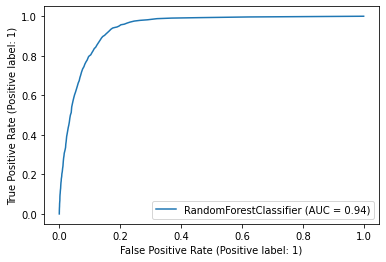

In [31]:
create_roc_auc_plot(model, X_test, y_test)

C:\Users\Ashutosh Tripathi\anaconda3\envs\mlops\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


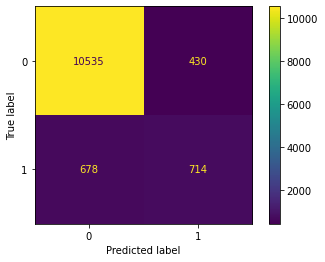

In [32]:
create_confusion_matrix_plot(model, X_test, y_test)

### MLFlow work Starts from here

In [36]:
experiment_name = "basic_classifier" ##basic classifier
run_name="term_deposit"
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
print(run_metrics)

{'accuracy': 0.91, 'precision': 0.62, 'recall': 0.51, 'entropy': 0.2}


In [40]:
create_experiment(experiment_name,run_name,run_metrics,model,'confusion_matrix.png', 'roc_auc_curve.png')

Run - term_deposit is logged to Experiment - basic_classifier


### Function to create an experiment in MLFlow and log parameters, metrics and artifacts files like images etc.

In [50]:
def create_experiment(experiment_name,run_name, run_metrics,model, confusion_matrix_path = None, 
                      roc_auc_plot_path = None, run_params=None):
    import mlflow
    #mlflow.set_tracking_uri("http://localhost:5000") #uncomment this line if you want to use any database like sqlite as backend storage for model
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run():
        
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
            
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        mlflow.sklearn.log_model(model, "model")
        
        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_materix')
            
        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        mlflow.set_tag("tag1", "Random Forest")
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})
            
    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))

### Create another experiment after tuning hyperparameters and log the best set of parameters for which model gives the optimal performance

In [41]:
import mlflow
experiment_name = "optimized model"
run_name="Random_Search_CV_Tuned_Model"
model_tuned,best_params = hyper_parameter_tuning(X_train, y_train)
run_params = best_params

y_pred = predict_on_test_data(model_tuned,X_test) #will return the predicted class
y_pred_prob = predict_prob_on_test_data(model_tuned,X_test) #model.predict_proba(X_test)
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\Ashutosh Tripathi\anaconda3\envs\mlops\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Random grid:  {'n_estimators': [5, 21, 51, 101], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 101, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}  



C:\Users\Ashutosh Tripathi\anaconda3\envs\mlops\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [42]:
run_metrics

{'accuracy': 0.91, 'precision': 0.61, 'recall': 0.57, 'entropy': 0.2}

In [43]:
for param in run_params:
    print(param, run_params[param])

n_estimators 101
min_samples_split 10
min_samples_leaf 4
max_features auto
max_depth 50
bootstrap True


In [51]:
create_experiment(experiment_name,run_name,run_metrics,model_tuned,'confusion_matrix.png', 'roc_auc_curve.png',run_params)

Run - Random_Search_CV_Tuned_Model is logged to Experiment - optimized model



### if want to use the model registry feature, we need a database.

#### _If you have MySQL installed then you can use the below command:_

1. Create a database to use as an MLflow backend tracking server.

`CREATE DATABASE mlflow_tracking_database;`

2. Start MLflow tracking server using MySQL as a backend tracking store.
` mlflow server \
   --backend-store-uri  mysql+pymysql://root@localhost/mlflow_tracking_database \ 
   --default-artifact-root  file:/./mlruns \
   -h 0.0.0.0 -p 5000`


3. Set the MLflow tracking uri (within code section).

  mlflow.set_tracking_uri("http://localhost:5000")

#### _If you have sqlite installed then you can use the below command:_

1. Start MLflow tracking server using sqlite as a backend tracking store.

`mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 0.0.0.0 --port 5000`


2. Set the MLflow tracking uri (within code section).
    
    mlflow.set_tracking_uri("http://localhost:5000")


You can also follow the official documentation for more information on backend database for model registry

https://www.mlflow.org/docs/latest/model-registry.html#model-registry-workflows

## Next steps:

Using MLFlow
* How deploy models from model registry
* Model serving both batch serving and online serving
* MLFlow pipelines
* Model Validation

# Thank You 